In [1]:
%load_ext autoreload
%autoreload 2
from fun import *
os.environ['QT_QPA_PLATFORM']='offscreen'

##### We will study the evolutionary history of the Gravin protein, first, by looking at this protein in different species.

##### Are the Gravin protein sequences in the model species homologous?

#### Remember our model species: 

qt.gui.icc: Unsupported ICC profile class 73636e72


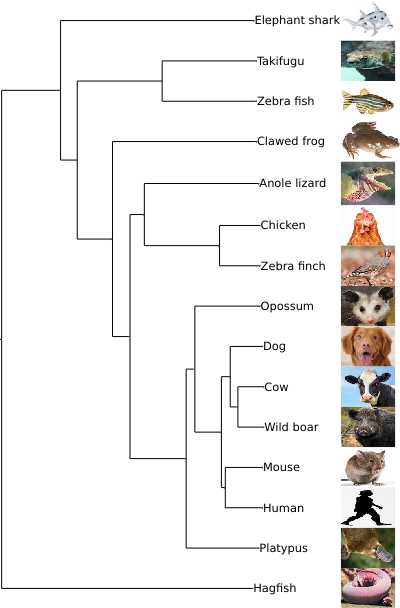

In [2]:
# Downloaded tree from timetreeoflife.org
nwk_direct = 'nwk_trees/model_species.nwk'
ts, t = render_phylogeny(nwk_direct, layout_tol)
t.render("%%inline", w=400, tree_style = ts) 


### Gravin human homologies

In [3]:
gravin_human = {fasta.id:str(fasta.seq) for fasta in SeqIO.parse(open("fasta_files/Homo_sapiens_Gravin_sequence.fa"),'fasta')}
order_list = list((NCBI_order_ids().keys()))


In [ ]:
# already in direct
for order, order_id in NCBI_order_ids().items():
    result_temp_handle = NCBIWWW.qblast("blastp", "nr",
                                        gravin_human['Gravin'],
                                        entrez_query = 'txid' + order_id + '[ORGN]')
    with open("blast_results/homo_sapiens_gravin/" + str(order) + ".xml", 'w') as f:
        f.write(result_temp_handle.getvalue())

In [4]:
blast_results = [read_blast_into_dict("blast_results/homo_sapiens_gravin/" + order + ".xml", key='12') for order in order_list]

hits_species_dict = {}
for result in blast_results:
    for hit_dict in result.values():
        if hit_dict['specie'] not in hits_species_dict:
            hits_species_dict[hit_dict['specie']] = []
        hits_species_dict[hit_dict['specie']].append((hit_dict['name'],hit_dict['e-value']))
        

In [5]:
df = generate_blast_df(species_host_to_guest_map_dic(), hits_species_dict)
df

specie  \
specie                                                  
Anolis carolinensis      29       Anolis carolinensis   
                         30       Anolis carolinensis   
                         31       Anolis carolinensis   
                         28       Anolis carolinensis   
Bos taurus               2                 Bos taurus   
                         3                 Bos taurus   
Callorhinchus milii      42       Callorhinchus milii   
                         41       Callorhinchus milii   
Canis lupus              4                Canis lupus   
                         5                Canis lupus   
Danio rerio              34               Danio rerio   
                         35               Danio rerio   
Gallus gallus            23             Gallus gallus   
                         26             Gallus gallus   
                         25             Gallus gallus   
                         27             Gallus gallus   
                         21             Gallus gallus   
                         24             Gallus gallus   
                         20             Gallus gallus   
                         22             Gallus gallus   
Monodelphis domestica    9      Monodelphis domestica   
                         11     Monodelphis domestica   
                         7      Monodelphis domestica   
                         12     Monodelphis domestica   
                         13     Monodelphis domestica   
                         14     Monodelphis domestica   
                         15     Monodelphis domestica   
                         6      Monodelphis domestica   
                         10     Monodelphis domestica   
                         8      Monodelphis domestica   
Mus musculus             0               Mus musculus   
Ornithorhynchus anatinus 17  Ornithorhynchus anatinus   
                         18  Ornithorhynchus anatinus   
                         19  Ornithorhynchus anatinus   
                         16  Ornithorhynchus anatinus   
Sus scrofa               1                 Sus scrofa   
Taeniopygia guttata      33       Taeniopygia guttata   
                         32       Taeniopygia guttata   
Takifugu rubripes        39         Takifugu rubripes   
                         38         Takifugu rubripes   
                         40         Takifugu rubripes   
Xenopus tropicalis       36        Xenopus tropicalis   
                         37        Xenopus tropicalis   

                                                                          name  \
specie                                                                           
Anolis carolinensis      29   PREDICTED: A-kinase anchor protein 12 isoform X1   
                         30   PREDICTED: A-kinase anchor protein 12 isoform X2   
                         31   PREDICTED: A-kinase anchor protein 12 isoform X3   
                         28   PREDICTED: A-kinase anchor protein 12 isoform X4   
Bos taurus               2               A-kinase anchor protein 12 isoform X1   
                         3               A-kinase anchor protein 12 isoform X1   
Callorhinchus milii      42             A-kinase anchor protein 12b isoform X1   
                         41             A-kinase anchor protein 12b isoform X2   
Canis lupus              4               A-kinase anchor protein 12 isoform X1   
                         5               A-kinase anchor protein 12 isoform X3   
Danio rerio              34              A-kinase anchor protein 12b isoform 1   
                         35              A-kinase anchor protein 12b isoform 2   
Gallus gallus            23              A-kinase anchor protein 12 isoform X1   
                         26              A-kinase anchor protein 12 isoform X1   
                         25              A-kinase anchor protein 12 isoform X2   
                         27              A-kinase anchor protein 12 isoform X2   
     

In [6]:
[i for i in list(species_host_to_guest_map_dic().keys()) if i not in [i.replace(' ', '_') for i in set(list(df['specie']))] and i != 'Homo_sapiens']


['Danio_rerio_akap12b', 'Danio_rerio_akap12a', 'Eptatretus_burgeri']

### Infer tree using the Jprime tool and DLRS model

In [7]:
## Multiple Sequence Alignment using MUSCLE
seq_filename = 'fasta_files/akap12_seq_prot.fa'
msa_filename = 'fasta_files/msa/akap12_seq_align_prot.fa'

In [ ]:
#already in direct
subprocess.call(["muscle","-in", seq_filename, "-out", msa_filename], 
                stdout=subprocess.DEVNULL,
                stderr=subprocess.STDOUT)

In [8]:
akap12_prot_seqs = {fasta.id:str(fasta.seq) for fasta in SeqIO.parse(open(seq_filename),'fasta')}

In [9]:
# specify files directory
guest2host_map_file = "jprime_files/input/guest2host_gravin_model_species.map"
out_file = "jprime_files/output/gravin_model_species.mcmc"
host_tree_file = "nwk_trees/model_species_tol_with_stem_edge_time-gravin.nwk"

In [ ]:
### already in directory
# Generate guest to host map file.
with open(guest2host_map_file, "w") as guest2host:
    for guest in list(akap12_prot_seqs.keys()):
        host = guest
        guest2host.write(guest + "\t" + host + "\n")
# Run DLRS model in jPrime
subprocess.call(["java", "-jar", "jprime-0.3.6.jar", "Delirious", 
                 "-o", out_file, "-i", "10000", #Number of iterations
                 "-sm", "JTT",
                 host_tree_file, msa_filename, guest2host_map_file], 
                stdout=subprocess.DEVNULL,
                stderr=subprocess.STDOUT)

### Infered tree using jPrime - DLRS model

In [11]:
chain = pd.read_table(out_file)
tree_filename = "jprime_files/output/DLRS_gravin_model_species_hom_tree.nwk"
dtree = dendropy.Tree.get_from_string(chain['GuestTree'].iloc[-1], "newick")
dtree.write_to_path(tree_filename, "newick", suppress_rooting=True)

In [12]:
ts, t = render_phylogeny(tree_filename, layout_tol)
for node in t.iter_descendants():
    node.dist*=30

##### The phylogeny of the gravin protein sequences do not agree with the tree of life.

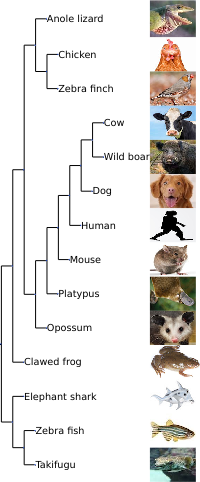

In [13]:
t.render("%%inline", w=200, tree_style = ts) 

In [ ]:
# Max-Likelihood phylogenetic tree using IQTREE with bootstrap
subprocess.call(["iqtree2", "-s", msa_filename, '-nt', 'AUTO'], 
                stdout=subprocess.DEVNULL,
                stderr=subprocess.STDOUT)

In [ ]:
ts, t = render_phylogeny('iqtree_files/iqtree_akap5_model_species_hom_tree.nwk', layout_tol)
for node in t.iter_descendants():
    node.dist*=30

In [ ]:
# Notes:
# - The msa returned by muscle changes depending on the version - why? - not nice!